In [1]:
#modeling data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

file = 'GoodReads_100k_books.csv'
book_data= pd.read_csv(file)

book_rategen = book_data.drop(columns= ['bookformat','img','pages','reviews','isbn','isbn13'])
book_rategen=book_rategen[['title', 'author', 'desc', 'genre', 'rating', 'totalratings', 'link']]
book_rategen=book_rategen.dropna(subset=['title'])
book_rategen.fillna(value='Not Provided', inplace=True)

In [2]:
#preprocessing and data training
book_rategen['genre']=book_rategen['genre'].str.replace('[^a-zA-Z]',' ')
book_rategen['genre']=book_rategen['genre'].str.lower()

from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(min_df=0.1, max_df=1.0)
cv.fit(book_rategen['genre'])
print(cv.get_feature_names_out())


['adult' 'art' 'cultural' 'fantasy' 'fiction' 'historical' 'history'
 'literature' 'nonfiction' 'not' 'provided' 'romance' 'science']


In [3]:
cv_transformed=cv.transform(book_rategen['genre'])
cv_array=cv_transformed.toarray()
print(cv_array.shape)

(99999, 13)


In [4]:
dummy=pd.get_dummies(book_rategen['genre'])
dummy.head()

,40k,"40k,audiobook","40k,fantasy,science fiction","40k,fiction,science fiction,fantasy","40k,games,gaming,science fiction,sports and games,games,games,role playing games","40k,science fiction","40k,science fiction,anthologies,fiction,short stories","40k,science fiction,fantasy","40k,science fiction,fantasy,anthologies,fiction","40k,science fiction,fantasy,fiction",...,"young adult,womens fiction,chick lit,fiction,romance,contemporary,young adult,teen,young adult,high school,childrens,middle grade,drama,childrens","young adult,womens fiction,chick lit,fiction,romance,young adult,teen,contemporary,young adult,high school,childrens,middle grade,realistic fiction,young adult,young adult contemporary","young adult,womens fiction,chick lit,fiction,romance,young adult,teen,contemporary,young adult,high school,childrens,middle grade,young adult,young adult contemporary,childrens","young adult,womens fiction,chick lit,fiction,young adult,teen,romance,contemporary,young adult,high school,childrens,middle grade,childrens,love","young adult,womens fiction,chick lit,romance,fiction,new york,contemporary,childrens,middle grade,young adult,teen,young adult,high school","young adult,world war ii,holocaust,war,historical,historical fiction,childrens,historical","young adult,young adult paranormal,young adult","young adult,young adult,coming of age,travel,road trip,realistic fiction,humor,cultural,contemporary","young adult,young adult,high school,romance,contemporary,realistic fiction,sociology,abuse,romance,m f romance,young adult,teen,fiction","young adult,young adult,teen,media tie in,tv,fiction,media tie in"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler=StandardScaler()
scaled_df=scaler.fit_transform(book_rategen[['rating']])



In [6]:
from sklearn.model_selection import train_test_split

X=book_rategen['rating']
y=book_rategen['totalratings']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100,test_size=0.25, shuffle=True)

In [7]:
print('X_train : ') 
print(X_train.head()) 
print('') 
print('X_test : ') 
print(X_test.head()) 
print('') 
print('y_train : ') 
print(y_train.head()) 
print('') 
print('y_test : ') 
print(y_test.head())

X_train : 
57881    3.84
27230    4.01
1921     4.17
87573    4.15
97191    4.50
Name: rating, dtype: float64

X_test : 
79668    3.82
83842    3.76
57026    3.67
53130    4.13
32612    3.93
Name: rating, dtype: float64

y_train : 
57881     45
27230    425
1921     441
87573    256
97191      6
Name: totalratings, dtype: int64

y_test : 
79668    102
83842     62
57026    198
53130      8
32612    734
Name: totalratings, dtype: int64


In [8]:
#build models 
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import lightgbm
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

In [9]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'Capstone 2 Ideas.docx',
 'Capstone2.ipynb',
 'Dataset',
 'GoodReads_100k_books.csv',
 'Modeling Capstone 2.ipynb',
 'Proposal.docx',
 'Proposal.pdf',
 'Untitled.ipynb',
 '~$oposal.docx',
 '~$pstone 2 Ideas.docx']

In [10]:
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
print(X_train.columns)

Index(['rating'], dtype='object')


In [11]:
categorical_features=['rating']

def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "num_threads" : 20,
        "min_child_samples" : int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : 0.03,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    lgtrain = lightgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lightgbm.cv(params,
                       lgtrain,
                       1000,
                       stratified=True,
                       nfold=3)
    return cv_result['valid auc-mean'][-1]

In [12]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (25, 4000),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 0.05),
                                                'lambda_l1': (0.0, 0.05),
                                                'min_child_samples': (50, 10000),
                                                'min_data_in_leaf': (100, 2000)
                                                })

lgbBO.maximize(n_iter=5, init_points=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
| 1         | 1.0       | 0.03567   | 0.005769  | 30.29     | 348.2     | 491.4     | 1.474e+03 |
| 2         | 1.0       | 0.01008   | 0.03096   | 39.3      | 4.02e+03  | 1.896e+03 | 471.2     |
| 3         | 1.0       | 0.03786   | 0.02098   | 27.79     | 8.218e+03 | 1.117e+03 | 3.377e+03 |
| 4         | 1.0       | 0.005129  | 0.0248    | 49.58     | 3.694e+03 | 1.107e+03 | 3.512e+03 |
| 5         | 1.0       | 0.01706   | 0.02012   | 13.94     | 9.908e+03 | 296.6     | 75.21     |
| 6         | 1.0       | 0.005291  | 0.005379  | 44.31     | 9.39e+03  | 1.982e+03 | 3.658e+03 |
| 7         | 1.0       | 0.001984  | 0.0476    | 22.96     | 4.55e+03  | 1.228e+03 | 1.098e+03 |


In [13]:
lgbBO.max

{'target': 1.0,
 'params': {'lambda_l1': 0.03566684189622381,
  'lambda_l2': 0.005768579472891483,
  'max_depth': 30.289970527576827,
  'min_child_samples': 348.19817329761224,
  'min_data_in_leaf': 491.41433542179664,
  'num_leaves': 1473.962353677072}}

In [14]:
lgbBO.res[0]

{'target': 1.0,
 'params': {'lambda_l1': 0.03566684189622381,
  'lambda_l2': 0.005768579472891483,
  'max_depth': 30.289970527576827,
  'min_child_samples': 348.19817329761224,
  'min_data_in_leaf': 491.41433542179664,
  'num_leaves': 1473.962353677072}}

In [15]:
#second model knn
sns.set()
random_seed_number=42
np.random.seed(random_seed_number)

X2=book_rategen.drop('rating', axis=1)
X_train2, X_test2, y_train2, y_test2=train_test_split(X2,y, test_size=0.3, random_state=100)

In [16]:
print(X_train2.head())

                          title                                  author  \
71947                Felt Craft                          Florence Temko   
21641  Third Girl from the Left                        Martha Southgate   
82642    Other People's Baggage  Kendel Lynn,Gigi Pandian,Diane Vallere   
14736                    Gordon                         Edith Templeton   
50978        Shane's Last Stand                       Suzanne Brockmann   

                                                    desc  \
71947                                       Not Provided   
21641  With ,Third Girl from the Left,, Southgate bri...   
82642  Baggage claim can be terminal when a computer ...   
14736  Originally written under a pseudonym, this thr...   
50978  Meet Shane Laughlin, the hero of bestselling a...   

                                                   genre  totalratings  \
71947                                       not provided             0   
21641  fiction,cultural,african american

In [17]:
from sklearn.linear_model import LinearRegression

scaler2 = StandardScaler()
if isinstance(X_train2, pd.DataFrame) and 'totalratings' in X_train2.columns:
    X_train2 = scaler2.fit_transform(X_train2['totalratings'].values.reshape(-1, 1))
if isinstance(X_test2, pd.DataFrame) and 'totalratings' in X_test2.columns:
    X_test2 = scaler2.transform(X_test2['totalratings'].values.reshape(-1, 1))

model = LinearRegression()
model.fit(X_train2, y_train2)

predictions = model.predict(X_test2)

In [18]:
from sklearn.neighbors import KNeighborsClassifier


test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train2,y_train2)
    
    train_scores.append(knn.score(X_train2,y_train2))
    test_scores.append(knn.score(X_test2,y_test2))

In [19]:
for i in range(len(test_scores)):
    if i == 0:
        print('k\tTrain_scores\tTest_scores')
    print(f'{i+1}\t{train_scores[i]: .5f}\t{test_scores[i]: .5f}')

k	Train_scores	Test_scores
1	 1.00000	 0.92980
2	 0.96350	 0.91133
3	 0.94234	 0.89823
4	 0.92667	 0.88617
5	 0.91804	 0.87987
6	 0.90664	 0.86937
7	 0.90097	 0.86493
8	 0.89174	 0.85707
9	 0.88551	 0.85193


In [20]:
index_max = max(range(len(train_scores)), key=train_scores.__getitem__)
index_max + 1

1

In [21]:
index_max_test = max(range(len(test_scores)), key=test_scores.__getitem__)
index_max_test + 1

1

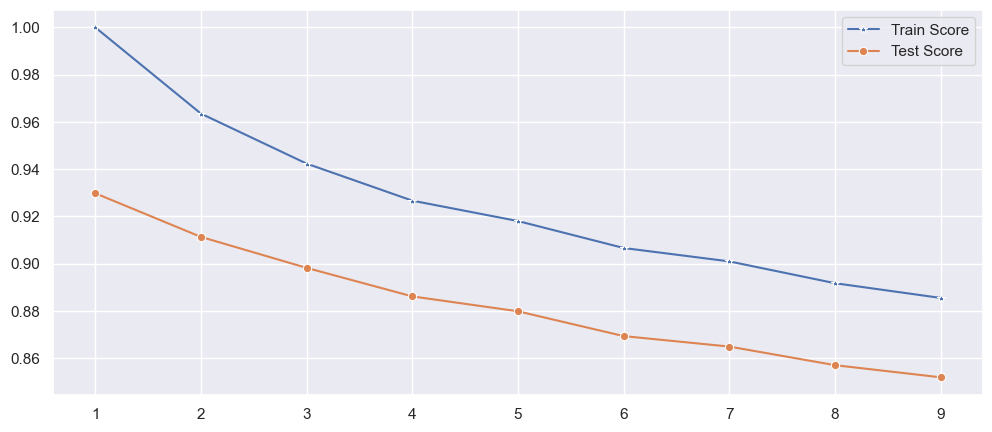

In [22]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1, 10), y=train_scores, marker='*', label='Train Score')
p = sns.lineplot(x=range(1, 10), y=test_scores, marker='o', label='Test Score')

In [23]:
knn2= KNeighborsClassifier(n_neighbors=1)
knn2.fit(X_train2, y_train2)
knn2.score(X_test2, y_test2)

0.9298

In [24]:
from sklearn.metrics import confusion_matrix
y_pred = knn2.predict(X_test2)
pl = confusion_matrix(y_test2,y_pred)

In [25]:
#print the p1 head
from sklearn.metrics import ConfusionMatrixDisplay
print(pl)

[[467   0   0 ...   0   0   0]
 [  0 526   0 ...   0   0   0]
 [  0   0 443 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   1   0]]


In [26]:
from sklearn.metrics import confusion_matrix,classification_report
# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test2,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       467
           1       1.00      1.00      1.00       526
           2       1.00      1.00      1.00       443
           3       1.00      1.00      1.00       386
           4       1.00      1.00      1.00       345
           5       1.00      1.00      1.00       332
           6       1.00      1.00      1.00       314
           7       1.00      1.00      1.00       284
           8       1.00      1.00      1.00       273
           9       1.00      1.00      1.00       268
          10       1.00      1.00      1.00       246
          11       1.00      1.00      1.00       219
          12       1.00      1.00      1.00       233
          13       1.00      1.00      1.00       226
          14       1.00      1.00      1.00       216
          15       1.00      1.00      1.00       217
          16       1.00      1.00      1.00       200
          17       1.00    

In [ ]:
# Based on the confusion matrix I think we should pick this model with the weighted average. This gives a great score and is close to one. 